# Basic NN example
In this notebook we'll examine to common supervised (we supply target data) machine learning tasks; regression (modeling a continuous distribution) and classification (modeling a discrete distribution).

Neural networks are made up of layers of 'neurons' each of which apply simple transformations to their inputs, but together allow the network to build up more advanced transformations of the data.
<img src="imgs/NN.png" width="600">

To begin with, we'll use a single neuron implemented in Numpy, with manual evaluation of gradients and parameter updates.

A single neuron with a single input means taking the input data, timesing by a parameter called the *weight* and offsetting the result with a second parameter called the *bias*. This result can then optionally be fed through a non-linear transformation function called the *activation function* We then want to tune these two parameters until the output matches the target values.

Diagrammatically, a neuron acts on a single input $x$, thusly:
<img src="imgs/Neuron.png" width="600">
Whilst not adding more beyond the mathematical expression $w\cdot x +b$, the diagram can sometimes be good to keep in mind when considering back-propagation of gradients.

In [294]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from time import sleep

# Regression
As an initial, simply example, we'll generate some pseudodata with a bit of noise.

In [295]:
x = np.random.uniform(size=100)
c = [3, -2]
y = c[0]*(x+np.random.normal(-0.05,0.05,size=100))+c[1]

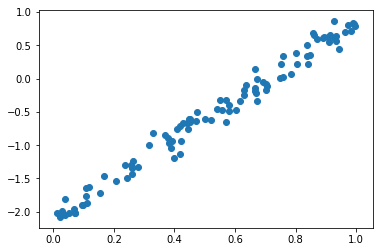

In [296]:
_ = plt.scatter(x, y)

The problem will be to predict the $y$ position of a data point, given it's $x$ value.

To determine how well the our solution works, we need to quantify its performance using a function called the *loss*. Many common loss functions exist, however the one which is most useful for out particular problem is the *mean squared-error* (MSE): Basically, the squared difference between our predicted value ($\hat{y}$) and the actual $y$ value, averaged over the number of data points we test. The factor of 0.5 is there to simplify some later equations.

An alternative loss function would be the mean absolute error. MAE scales linearly with the error, meaning that it will continue to offer penalities even for small errors, whereas MSE reduces its penalties for small errors and instead offers great suppression of very poor predictions - effectively it aims to quickly get predictions in *about the right area*, which is often what we're more interested. MSE is however, sensitive to anomalous outliers in the data.

In [297]:
def loss(y_hat, y): return np.square(y_hat-y).mean()/2

In [298]:
def mae(y_hat, y): return np.abs(y_hat-y).mean()/2

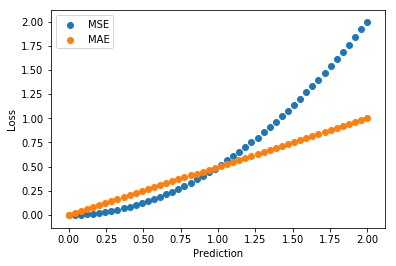

In [299]:
a = np.linspace(0,2)
plt.scatter(a, [loss(b, 0) for b in a], label='MSE')
plt.scatter(a, [mae(b, 0) for b in a], label='MAE')
plt.xlabel('Prediction')
plt.ylabel('Loss')
plt.legend();

We need to have some initial values to get a starting prediction. For the weight, which times the $x$ values, we'll samples a Gaussian centred at zero with standard deviation one. The initial bias, which is then added to $w\cdot b$, we start from zero.

In [300]:
w = np.random.normal()
b = 0
y_hat = w*x+b

Our set of predictions is then $\hat{y}=w\cdot x+b$

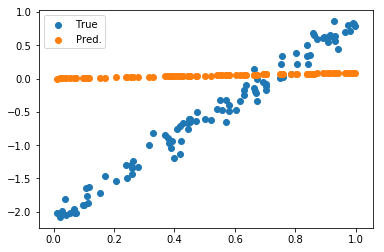

In [301]:
_ = plt.scatter(x, y, label='True')
_ = plt.scatter(x, y_hat, label='Pred.')
plt.legend();

Unless we were extremely luck with the random initialisation, its unlikely that the predictions will line up with the true values. However we are now able to evaluate the performance of our model using the loss function. We can then use the gradient of the loss to work out the effect of each parameter on the loss, by evaluating analytically its local gradient and timesing it to the incoming gradient via the chain rule (backpropagation). Once we know the loss gradient with respect to each parameter, we can step in the direction of steepest slope by an amount determined by the *learning rate*, which we set before hand.

This iterative updating of parameters in the direction of steepest slope is called *gradient descent*, and should eventually lead us to a local minimum in the loss surface.
<img src="imgs/gradient-descent.png" width="300">
[Image source](https://livetoideate.com/machine-learning/gradientdescent/)

Evaluating the loss gradients with respect to the network parameters first requires evaluating the gradient of the loss with respect to our prediction: $\frac{\partial\mathcal{L}}{\partial\hat{y}}$. For MSE this is $\hat{y}-y$.

We can then backpropagate this loss gradient to the bias: $\frac{\partial\mathcal{L}}{\partial b}=\frac{\partial\mathcal{L}}{\partial\hat{y}}\times\frac{\partial\hat{y}}{\partial b}$, we simply need to evaluate $\frac{\partial\hat{y}}{\partial b}$. $\frac{\partial \left(w\cdot x+b\right)}{\partial b}=\frac{\partial b}{\partial b}=1$. So $\frac{\partial\mathcal{L}}{\partial b}=\frac{\partial\mathcal{L}}{\partial\hat{y}}=\hat{y}-y$

Similarly for the weight:$\frac{\partial\mathcal{L}}{\partial w}=\frac{\partial\mathcal{L}}{\partial\hat{y}}\times\frac{\partial\hat{y}}{\partial w}=\frac{\partial\mathcal{L}}{\partial\hat{y}}\times\frac{\partial \left(w\cdot x+b\right)}{\partial w}=\frac{\partial\mathcal{L}}{\partial\hat{y}}\times x=x\left(\hat{y}-y\right)$

Since we want to step down the gradient, updates will be of the form $w\prime=w-lr\frac{\partial\mathcal{L}}{\partial w}$, where $lr$ is the learning rate.

Epoch 480, loss 0.008 y=2.828x+-2.018


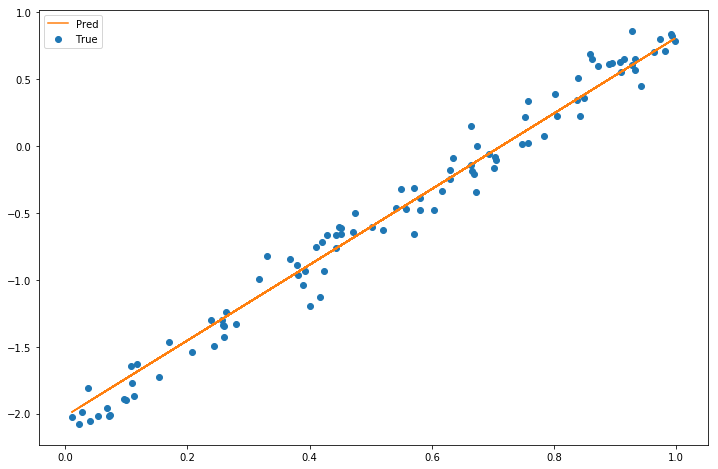

In [305]:
w_orig, b_orig = w, b
lr = 0.1
y_hat = w*x+b

with sns.color_palette('tab10') as palette:
    for i in range(500):
        l = loss(y_hat, y)
        dl = y_hat-y
        dw = (dl*x).mean()
        db = dl.mean()
        w -= lr*dw
        b -= lr*db
        y_hat = w*x+b
        if i%20 == 0:
            print(f'Epoch {i}, loss {l:.3f} y={w:.3f}x+{b:.3f}')
            plt.figure(figsize=(12,8))
            plt.scatter(x, y,  label="True", color=palette[0])
            plt.plot(x, y_hat, label='Pred', color=palette[1])
            plt.legend()
            plt.show()
            sleep(0.1)
            clear_output(wait=True)

w, b = w_orig, b_orig

As we can see, the model parameters make larger updates in the beginning, when the prediction errors are high and then eventually converge to values which lie almost in the centre of the traing data

# Binary classification
Another common problem, is trying to identify the discrete 'class' of a data point. For this we'll again generate some pseudodata, with points of class 0 and class 1.

In [333]:
x = 2*np.random.uniform(size=100)
x.sort()
c = 1
y = np.zeros_like(x)
y[x > c] = 1

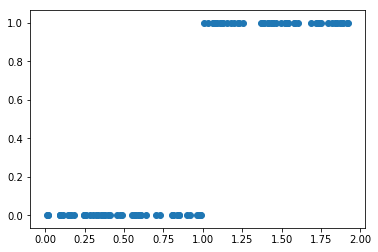

In [334]:
_ = plt.scatter(x, y)

For this problem we want to use a slightly different loss function, called *binary crossentropy*, which uses the natural logs to heavily penalise the sevear misclassification of each class. 

In [335]:
def loss(y_hat, y): return -(y*np.log(y_hat)+(1-y)*np.log(1-y_hat)).mean()

/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


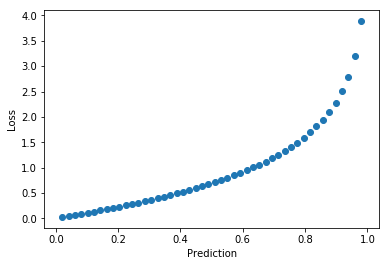

In [336]:
a = np.linspace(0,1)
plt.scatter(a, [loss(b, 0) for b in a])
plt.xlabel('Prediction')
plt.ylabel('Loss');

Since the backpropagation will be a bit more involved for this, we'll use a function to compute the loss gradient.

In [337]:
def dl_dy_hat(y, y_hat): return (1-y)/(1-y_hat)-y/y_hat

A linear function on its own won't be enough to model the classes. We need to use an *activation function*; a non-linear fucntion of the output of our model. For binary classification, the sigmoid is useful since it offers convergence to both zero and one, with a smoot interpolation between the two.

In [338]:
def sigmoid(x): return 1/(1+np.exp(-x))

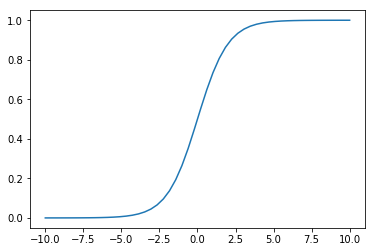

In [339]:
a = np.linspace(-10, 10)
_ = plt.plot(a, sigmoid(a))

We'll also need its derivative.

In [340]:
def dsig_dx(x):
    s = sigmoid(x)
    return s*(1-s)

In [341]:
w = np.random.normal()
b = 0
y_hat = sigmoid(w*x+b)

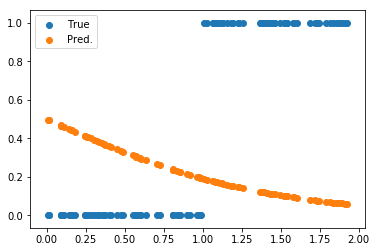

In [342]:
_ = plt.scatter(x, y, label='True')
_ = plt.scatter(x, y_hat, label='Pred.')
plt.legend();

Our starting parameters fail to model the data out of the box, however as we did for the regression proble, we can compute gradients and backpropagate them to the model parameters. Due to the activation function, the formulae are bit more complicated, however as we saw earlier, the local gradients can be constructed in terms of already computed derivatives via the chain rule.

Epoch 950, loss 0.087 y=10.215x+-10.090


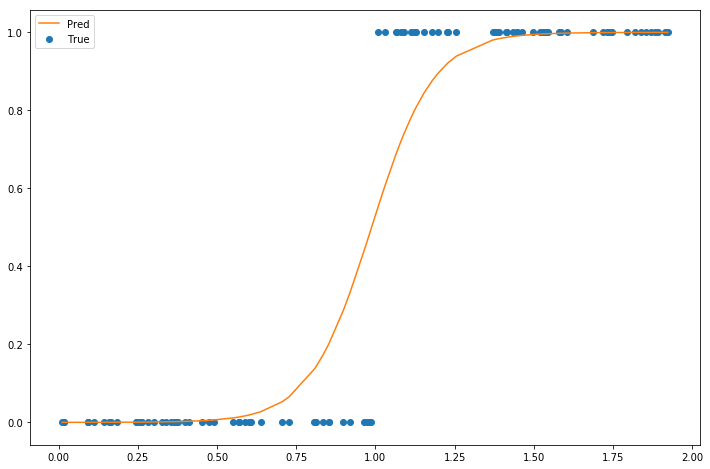

In [346]:
w_orig, b_orig = w, b
lr = 1
y_hat = w*x+b

with sns.color_palette('tab10') as palette:
    for i in range(1000):
        l = loss(y_hat, y)
        dl = dl_dy_hat(y, y_hat)
        ds = dsig_dx(w*x+b)
        dw = (dl*ds*x).mean()
        db = (dl*ds).mean()
        w -= lr*dw
        b -= lr*db
        y_hat = sigmoid(w*x+b)
        if i%50 == 0:
            print(f'Epoch {i}, loss {l:.3f} y={w:.3f}x+{b:.3f}')
            plt.figure(figsize=(12,8))
            plt.scatter(x, y,  label="True", color=palette[0])
            plt.plot(x, y_hat, label='Pred', color=palette[1])
            plt.legend()
            plt.show()
            sleep(0.1)
            clear_output(wait=True)

w, b = w_orig, b_orig